In [1]:
import numpy as np
import xarray as xr
import itertools
import matplotlib.pyplot as plt
from cartopy import geodesic
import cartopy.crs as ccrs
import shapely
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import analysis_functions as funk
import cartopy.feature as cfeature
from cycler import cycler

from scipy.stats import kde

In [2]:
initial_depth = -5100  # int(sys.argv[1])  # 5 # 60 # 5179
lon_sample = 6.287  # 6.25
lat_sample = -32.171  # -32.171
origin = (lon_sample, lat_sample)

start_time = datetime.strptime('2019-01-20 12:00:00', '%Y-%m-%d %H:%M:%S')
sim_time = 4484
# create the date range in reverse from sampling time to the past
datelist = pd.date_range(end=start_time, periods=sim_time)[::-1]
end_time = datelist[0]

# simulations = [10] + [i for i in range(100, 501, 100)]
simulations = [100, 1000, 10000, 23000]

In [3]:
surface_events = np.load('../data/surface_events.npy', allow_pickle=True).item()

In [4]:
ds = pd.read_csv('../data/size_distribution_surface.csv', index_col=0)

In [5]:
mask = xr.open_dataset('../data/PSY4V3R1_mask.nc')
indices = {'lat': range(400, 1600), 'lon': range(2000, 4300)}
landmask = mask['tmask'][0, 0, indices['lat'], indices['lon']]
xlon = mask['nav_lon'][indices['lat'], indices['lon']].values
ylat = mask['nav_lat'][indices['lat'], indices['lon']].values

# mask the cell of the land == 0 
landmask = landmask.values
landmask = landmask.astype(float)

coarsing = 5

landmask = landmask[::coarsing, ::coarsing]
landmask[landmask == 0] = np.nan
ocean = np.isnan(landmask)
ocean = ocean.flatten()
xlon = xlon[::coarsing, ::coarsing]
ylat = ylat[::coarsing, ::coarsing]


/tmp/ipykernel_816388/762311612.py:15: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x, y])


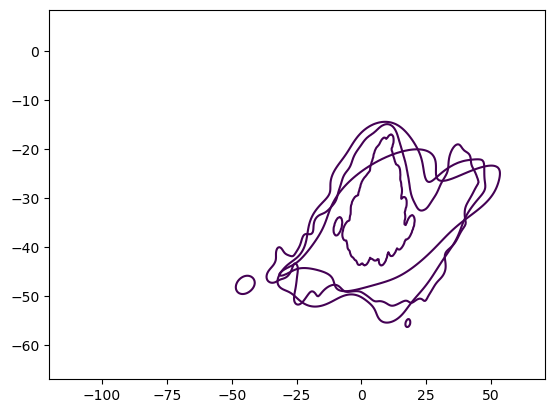

In [6]:
all_contours = {}
percentile = 0.9

xi, yi = xlon, ylat
XY = np.vstack([xi.flatten(), yi.flatten()])

ocean = ocean.flatten()
# XY = XY[:, ocean]

for j, ft in enumerate(simulations[::-1]):
    x = surface_events[ft]['lon']
    y = surface_events[ft]['lat']

    # Perform a kernel density estimate on the data
    k = kde.gaussian_kde([x, y])
    zi = k(XY)
    zi_masked = np.where(ocean, zi, np.nan)

    # Find density level that includes 90% of the particles
    zi_sorted = np.sort(zi_masked.flatten())
    cumulative_zi = np.cumsum(zi_sorted)
    cumulative_zi = cumulative_zi[~np.isnan(zi_sorted)]
    level = zi_sorted[np.where(cumulative_zi >= cumulative_zi[-1] * (1 - percentile))[0][0]]

    # Plot contours at this density level
    contours = plt.contour(xi, yi, zi.reshape(xi.shape), levels=[level])
    
    # Get the contour lines
    largest_contour_line = None
    max_length = 0
    contour_lines = []
    for collection in contours.collections:
        for path in collection.get_paths():
            if len(path.vertices) > max_length:
                max_length = len(path.vertices)
                largest_contour_line = path.vertices
    all_contours[ft] = largest_contour_line 
    

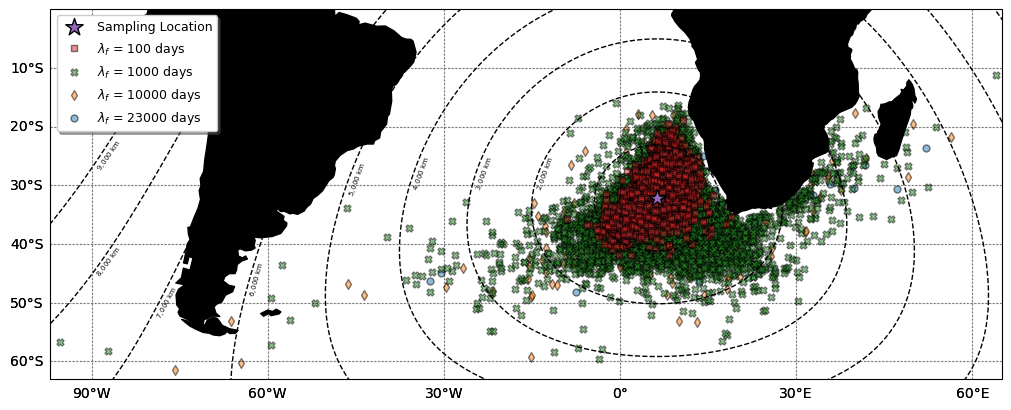

In [9]:
marker = itertools.cycle(('o', 'd', 'X', 's'))
line_styles = itertools.cycle(['--', '-', ':', '-.'])

fig,ax = plt.subplots(figsize=(10,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=5, color='black')
# ax.add_feature(cfeature.COASTLINE)

for j, ft in enumerate(simulations[::-1]):    
    ax.scatter(surface_events[ft]['lon'], surface_events[ft]['lat'],
               zorder=2, s=25, alpha=0.5, edgecolors='black',
               label=f"$\lambda_f$ = {ft} days", marker=next(marker))

# for j, ft in enumerate(simulations[::-1]):  
#     ax.plot(all_contours[ft][:, 0], all_contours[ft][:, 1], label=f"$\lambda_f$ = {ft} days - {int(percentile*100)}% Contour",
#             lw=5)
#     ax.plot(all_contours[ft][:, 0], all_contours[ft][:, 1], c='k',
#             lw=1, ls=next(line_styles))

ax.scatter(origin[0], origin[1], zorder=5,
           label='Sampling Location', marker='*', s=170, edgecolors='black')

for r in range(1, 10, 1):
    circle_points = geodesic.Geodesic().circle(lon=origin[0], lat=origin[1],
                                               radius=r*1e6,
                                               n_samples=360,
                                               endpoint=False)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none',
                      edgecolor='black', linewidth=1., zorder=3, ls='--',
                      label=f'{r} km')
ax.text(3.3, -24.5, r"$1,000$ km", fontsize=5)
ax.text(-14.5, -30.5, r"$2,000$ km", fontsize=5, rotation=70)
ax.text(-25., -30.5, r"$3,000$ km", fontsize=5, rotation=70)
ax.text(-35.6, -30.5, r"$4,000$ km", fontsize=5, rotation=70)
ax.text(-46.6, -31.5, r"$5,000$ km", fontsize=5, rotation=70)
ax.text(-63.5, -48.5, r"$6,000$ km", fontsize=5, rotation=75)
ax.text(-79.3, -52.5, r"$7,000$ km", fontsize=5, rotation=62)
ax.text(-89.5, -45.3, r"$8,000$ km", fontsize=5, rotation=53)
ax.text(-89.5, -27.3, r"$9,000$ km", fontsize=5, rotation=55)

handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
# handles = [handles[0]] + handles[5:] + handles[slice(1,5)]
labels = labels[::-1]
# labels = [labels[0]] + labels[5:] + labels[slice(1,5)]

# reorder = (np.array([0, 5, 6, 7, 8, 1, 2, 3, 4]))
# handles = list(np.array(handles)[reorder])
# labels = list(np.array(labels)[reorder])

ax.set_extent([-97, 65, -63, 0], crs=ccrs.PlateCarree())

ax.legend(handles, labels, ncols=1, fontsize=9, shadow=True, loc='upper left') 
fig.savefig('../article_figs/Figure3.png', dpi=300,
            facecolor=(1, 0, 0, 0))

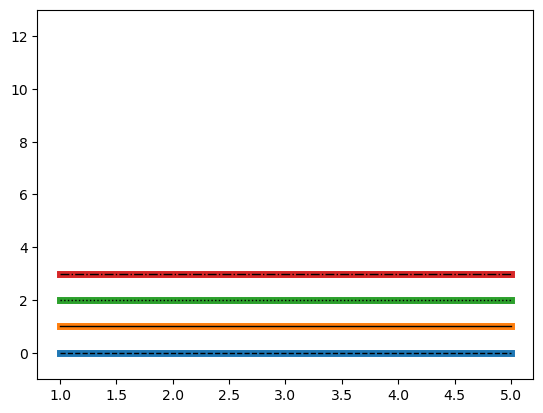

In [23]:
# patch the legend manually

# Create some data
x = np.array([1, 2, 3, 4, 5])
y = np.zeros_like(x)


for j, ft in enumerate(simulations[::-1]):
    plt.plot(x, y+j, label=f"$\lambda_f$ = {ft} days", lw=5)
    plt.plot(x, y+j, c='k', lw=1, ls=next(line_styles))
    
plt.ylim(-1, 13)
plt.savefig('../article_figs/Figure3_legend_patch.png', dpi=300,
            facecolor=(1, 0, 0, 0))

Best alternative, but it doesn plot different linestyle for the thick and narrow one. 

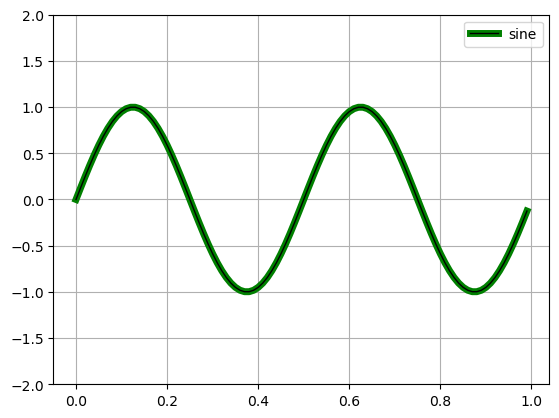

In [24]:
import matplotlib.patheffects as pe
 
# setup data
x = np.arange(0.0, 1.0, 0.01)
y = np.sin(2*2*np.pi*x)
 
# create line plot including an outline (stroke) using path_effects
plt.plot(x, y, color='k', lw=1, path_effects=[pe.Stroke(linewidth=5, foreground='g'), pe.Normal()], label='sine')
# custom plot settings
plt.grid(True)
plt.ylim((-2, 2))
plt.legend()
plt.show()

# FIGURE S2 - Maps of fragmenting location

In [25]:
frag_into_NPs = np.load('../data/frag_into_NPs.npy', allow_pickle=True)[()]

In [26]:
frag_

{100: {'particle_index': array([ 69, 154,  66, ..., 117, 152, 146]),
  'depths': array([-5011.57144693, -4892.29941965, -4945.46732921, ...,
         -5038.52266963, -4447.834448  , -5013.07258543]),
  'lat': array([-30.22228815, -27.89727743, -30.40613523, ..., -30.16405676,
         -28.32768866, -29.97843726]),
  'lon': array([7.72518577, 6.75305881, 7.75767181, ..., 5.24781808, 6.73517992,
         7.68949454]),
  'displacement': array([256245.38258325, 477327.44385616, 240909.89247469, ...,
         244079.67746255, 429517.92592574, 277985.01212607]),
  'counts': array([8192., 8135., 8067., ...,    0.,    0.,    0.]),
  'vertical_distribution': masked_array(
    data=[[--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          ...,
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --]],
    mask=[[ True,  True,  True, ...,  True,  True,  True],
       

In [57]:
depthz = frag_into_NPs[ft]['depths']

# can you sort the depths and give me the indexes of the sorted array
sorted_indexes = np.argsort(frag_into_NPs[ft]['depths'])

In [69]:
percentile_index = int(depthz.shape[0]*percentile_s2)

In [72]:
depthz[:percentile_index].shape

(8110,)

/tmp/ipykernel_260242/384364213.py:22: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x, y])


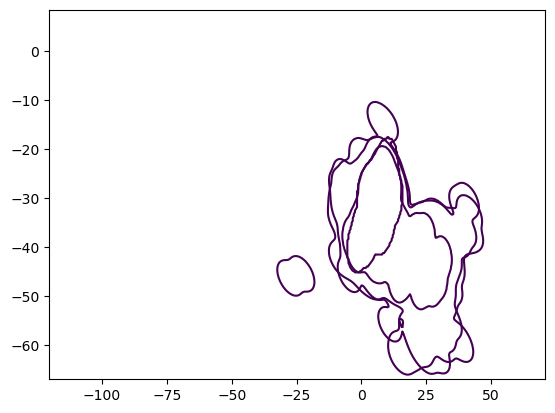

In [98]:
all_contours_s2 = {}
percentile_s2 = 0.5

xi, yi = xlon, ylat
XY = np.vstack([xi.flatten(), yi.flatten()])

ocean = ocean.flatten()
# XY = XY[:, ocean]

for j, ft in enumerate(simulations[::-1]):
    depthz = frag_into_NPs[ft]['depths']
    sorted_indexes = np.argsort(frag_into_NPs[ft]['depths'])
    percentile_index = int(depthz.shape[0]*percentile_s2)
    
    x = frag_into_NPs[ft]['lon'][sorted_indexes]
    y = frag_into_NPs[ft]['lat'][sorted_indexes]
    
    x = x[:percentile_index]
    y = y[:percentile_index]

    # Perform a kernel density estimate on the data
    k = kde.gaussian_kde([x, y])
    zi = k(XY)
    zi_masked = np.where(ocean, zi, np.nan)

    # Find density level that includes 90% of the particles
    zi_sorted = np.sort(zi_masked.flatten())
    cumulative_zi = np.cumsum(zi_sorted)
    cumulative_zi = cumulative_zi[~np.isnan(zi_sorted)]
    level = zi_sorted[np.where(cumulative_zi >= cumulative_zi[-1] * (1 - 0.99))[0][0]]

    # Plot contours at this density level
    contours = plt.contour(xi, yi, zi.reshape(xi.shape), levels=[level])
    
    # Get the contour lines
    largest_contour_line = None
    max_length = 0
    contour_lines = []
    for collection in contours.collections:
        for path in collection.get_paths():
            if len(path.vertices) > max_length:
                max_length = len(path.vertices)
                largest_contour_line = path.vertices
    all_contours_s2[ft] = largest_contour_line 
    

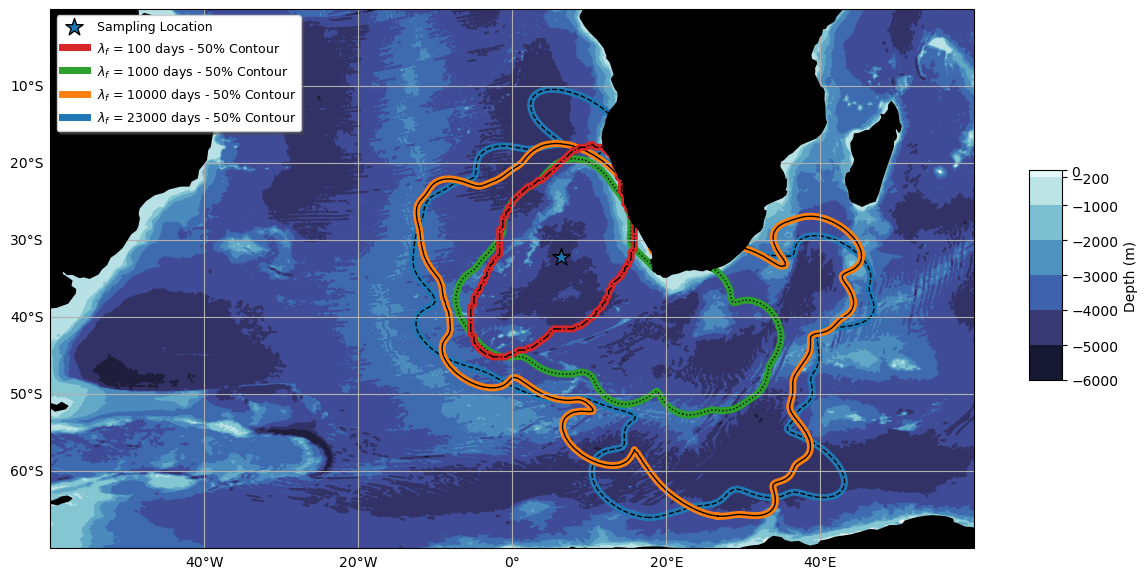

In [99]:
# marker = itertools.cycle(('o', 'd', 'X', 's'))
line_styles = itertools.cycle(['--', '-', ':', '-.'])

fig, ax = funk.bathymetry_plot(alpha=1, land_zorder=5)

# j = 3
# ft = 23000

# ax.scatter(frag_into_NPs[ft]['lon'], frag_into_NPs[ft]['lat'], zorder=2,
#             s=25, edgecolors='k', alpha=0.5,
#             label=f"$\lambda_f$ = {ft} days",
#             marker=next(marker))
    
    
for j, ft in enumerate(simulations[::-1]):  
    ax.plot(all_contours_s2[ft][:, 0], all_contours_s2[ft][:, 1], label=f"$\lambda_f$ = {ft} days - {int(percentile_s2*100)}% Contour",
            lw=5)
    ax.plot(all_contours_s2[ft][:, 0], all_contours_s2[ft][:, 1], c='k',
            lw=1, ls=next(line_styles))

ax.scatter(origin[0], origin[1], zorder=5,
           label='Sampling Location', marker='*', s=170, edgecolors='black')


handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]
# reorder = (np.array([0, 5, 6, 7, 8, 1, 2, 3, 4]))
# handles = list(np.array(handles)[reorder])
# labels = list(np.array(labels)[reorder])

ax.set_extent([-60, 60, -70, 0], crs=ccrs.PlateCarree())
ax.legend(handles, labels, ncols=1, fontsize=9, shadow=True, loc='upper left')


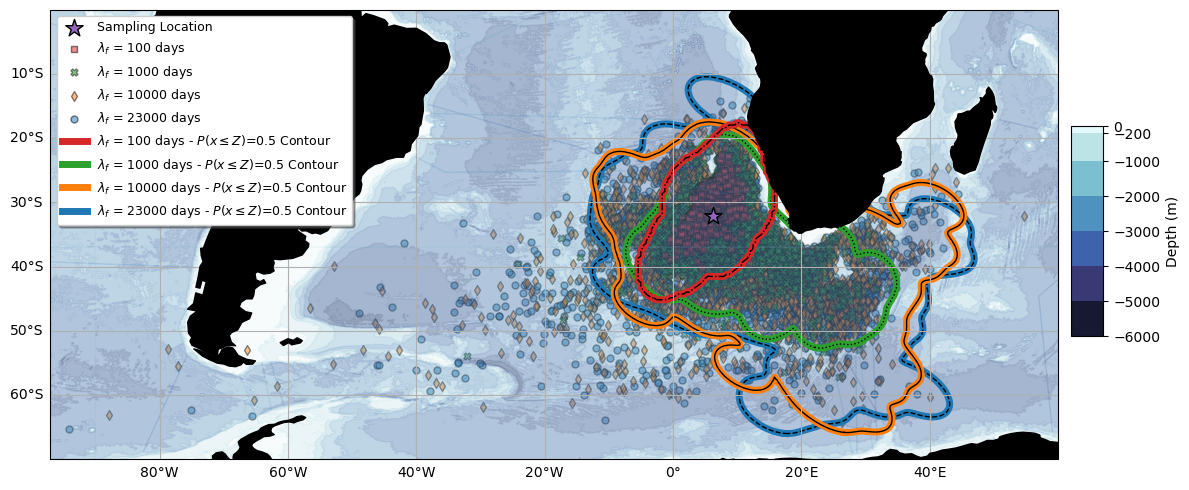

In [100]:
# %% FIGURE S2 - Maps of fragmenting location
# marker = itertools.cycle(('v', 'h', 'd', 'o', 'X', 'P', '^', 's'))
marker = itertools.cycle(('o', 'd', 'X', 's'))
line_styles = itertools.cycle(['--', '-', ':', '-.'])

fig, ax = funk.bathymetry_plot(alpha=0.1, land_zorder=5)

for j, ft in enumerate(simulations[::-1]):
    ax.scatter(frag_into_NPs[ft]['lon'], frag_into_NPs[ft]['lat'], zorder=1,
               s=25, edgecolors='k', alpha=0.5,
               label=f"$\lambda_f$ = {ft} days",
               marker=next(marker))
    
    
for j, ft in enumerate(simulations[::-1]):  
    ax.plot(all_contours_s2[ft][:, 0], all_contours_s2[ft][:, 1], label=f"$\lambda_f$ = {ft} days - $P(x \leq Z)$={percentile_s2} Contour",
            lw=5)
    ax.plot(all_contours_s2[ft][:, 0], all_contours_s2[ft][:, 1], c='k',
            lw=1, ls=next(line_styles))

ax.scatter(origin[0], origin[1], zorder=5,
           label='Sampling Location', marker='*', s=170, edgecolors='black')


handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]
reorder = (np.array([0, 5, 6, 7, 8, 1, 2, 3, 4]))
handles = list(np.array(handles)[reorder])
labels = list(np.array(labels)[reorder])

ax.set_extent([-97, 60, -70, 0], crs=ccrs.PlateCarree())

ax.legend(handles, labels, ncols=1, fontsize=9, shadow=True, loc='upper left')

fig.savefig('../article_figs/FigureS2.png', dpi=300,
            facecolor=(1, 0, 0, 0))
